<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/notebooks/aula_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2

Essa aula faz parte do módulo 3 sobre séries temporais do bootcamp de DataSciance aplicada da Alura. Aqui vamos começar, de fato, a trabalhar com a ferramenta do facebook, `prophet`. Os dados trabalhados durante todo o módulo serão dados públicos do [governo de São Paulo](https://www.seade.gov.br/coronavirus/) sobre os **casos de corona vírus**. Os dados já foram retirados do site e disponibilizados pelo github da Alura no dia 18/05/2021, [neste repositório](https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip).

## Obtendo os dados

In [ ]:
import pandas as pd

url = 'https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip?raw=true'
dados = pd.read_csv(url, compression='zip', sep=';')
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0,8.0,"-21,6820","-51,0737",9
1,Adolfo,3500204,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


In [ ]:
# tratando os dados

dados['datahora'] = pd.to_datetime(dados['datahora'], format='%Y-%m-%d')
dados_sp = dados.query('nome_munic == "São Paulo"')
print(dados_sp.shape)
dados_sp.head()

(443, 26)


,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
562,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
1207,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
1852,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
2497,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9
3142,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9


## Iniciando com o prophet

Para trabalhar com o prophet, precisamos de um data frame (`df`) que tenha 2 colunas com nomes específicos para as funções da biblioteca. Os nomes das colunas serão `ds`, que recebe os dados de **tempo**, e `y`, que recebe os dados referente àquilo **que queremos prever**, no caso, os casos de covid registrados por dia.

In [ ]:
# preparando o df para utilizar

df = pd.DataFrame()
df['ds'] = dados_sp['datahora']
df['y'] = dados_sp['casos_novos']

In [ ]:
# importando o prophet
from fbprophet import Prophet

# instanciando o objeto
modelo = Prophet()

In [ ]:
# aplicando o modelo para fazer o ajuste da curva com os dados que temos

modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Percebemos que o fbprophet já fez algumas considerações sobre os nossos dados. Ele desabilitou as sazonalidades diárias e anuais, ou seja, identificou que não existe esse padrão nos dados apresentados.

## Primeiras previsões

Vamos fazer um novo dataframe que conterá as informações que queremos prever, dias no futuro. Através do método `make_future_dataframe` podemos fornecer previsões escolhendo até mesmo o período de tempo que queremos prever, passando o parâmetro `periods`. Vamos fazer uma previsão de 30 dias.

In [ ]:
df_futuro = modelo.make_future_dataframe(periods=30)
df_futuro.tail()

,ds
468,2021-06-07
469,2021-06-08
470,2021-06-09
471,2021-06-10
472,2021-06-11


Perceba que o dataframe termina com as últimas datas que escolhemos para previsão. Agora faremos de fato a previsão, colocando os resultados em **outro dataframe** chamado `previsao`

In [ ]:
previsao = modelo.predict(df_futuro)
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-114.303728,-734.627256,1595.294036,-114.303728,-114.303728,500.316952,500.316952,500.316952,500.316952,500.316952,500.316952,0.0,0.0,0.0,386.013224
1,2020-02-26,-96.932780,-710.034264,1649.272941,-96.932780,-96.932780,554.767711,554.767711,554.767711,554.767711,554.767711,554.767711,0.0,0.0,0.0,457.834930
2,2020-02-27,-79.561833,-511.528291,1752.183174,-79.561833,-79.561833,650.710000,650.710000,650.710000,650.710000,650.710000,650.710000,0.0,0.0,0.0,571.148167
3,2020-02-28,-62.190885,-890.081245,1483.247549,-62.190885,-62.190885,368.442066,368.442066,368.442066,368.442066,368.442066,368.442066,0.0,0.0,0.0,306.251181
4,2020-02-29,-44.819937,-1248.454306,1197.886394,-44.819937,-44.819937,30.824737,30.824737,30.824737,30.824737,30.824737,30.824737,0.0,0.0,0.0,-13.995200


Nesse data frame agora, temos na última coluna o `yhat`, que são os valores estimados para y.

Vamos realizar um plot do dataframe com o prophet para entender melhor o que o método de previsão faz.

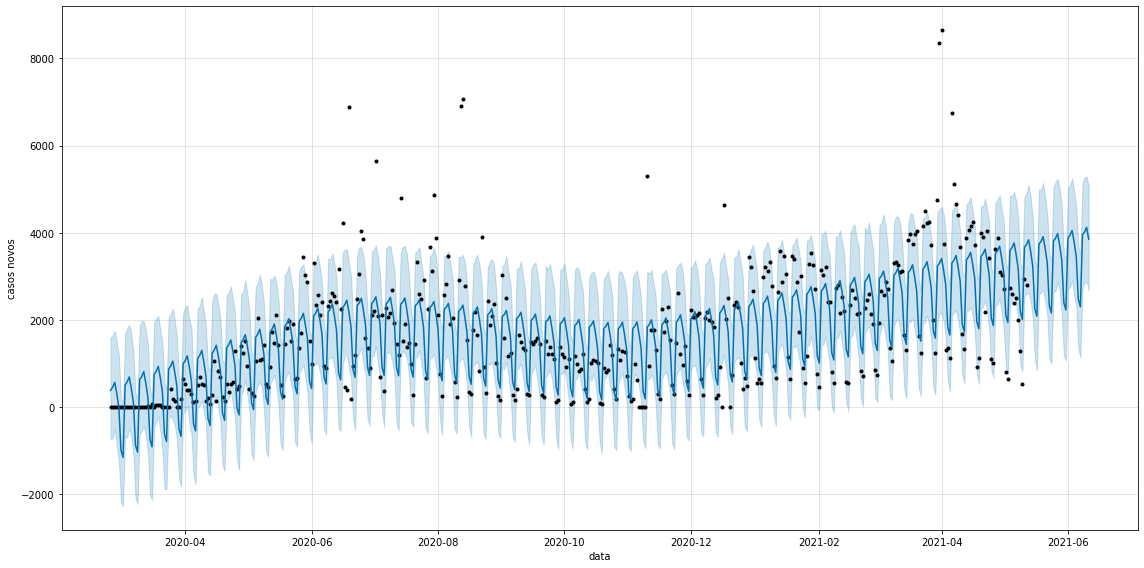

In [ ]:
modelo.plot(previsao, xlabel='data', ylabel='casos novos', figsize=(16,8));   # o ; é necessário para não acontecer do prophet plotar 2 figuras iguais.

Explicando o gráfico, os pontos pretos são os dados que temos, a curva azul escura é a curva ajustada pelo modelo e por fim a faixa azul clara é o intervalo de confiança. Essa faixa é determinada pelas colunas `yhat_upper` e `yhat_lower`, vistas no dataframe acima.

Agora percebemos que a curva ajustada segue exatamente um padrão de sazonalidade semanal, que foi identificada pelo fbprophet quando executamos `.modelo.fit()`.

## Separando dados de teste e de treino

Quando estamos usando algoritmos de machine learning, é muito importante separar os dados que temos para **teste** e **treino**, afim de validar o modelo que estamos utilizando. Aqui, vamos separar os primeiros 400 dias para usarmos como dados de treino, e o restante dos 43 dias usaremos como teste da previsão do modelo. Geralmente, 70% dos dados são direcionados a treino e os outros 30% para teste.

In [ ]:
df = pd.DataFrame()
df['ds'] = dados_sp['datahora'][:400]
df['y'] = dados_sp['casos_novos'][:400]
display(df.head())
df.shape

,ds,y
562,2020-02-25,0
1207,2020-02-26,0
1852,2020-02-27,0
2497,2020-02-28,1
3142,2020-02-29,0


(400, 2)

Agora, vamos fazer a previsão para os próximos 43 dias.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


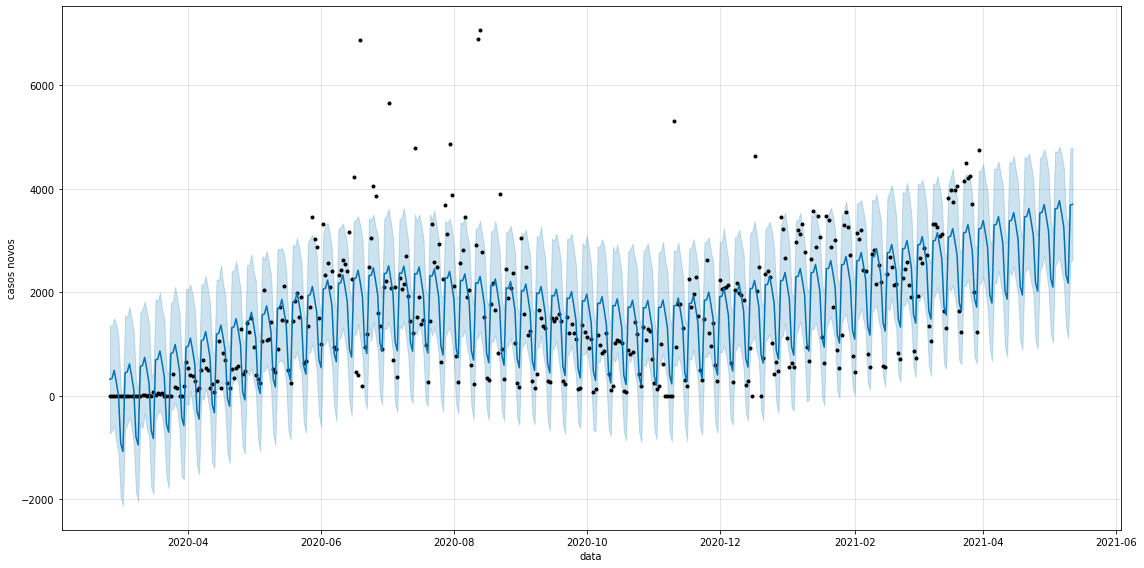

In [ ]:
# precisamos instanciar um novo objeto para fazer uma nova previsão
modelo = Prophet()

# refazendo o modelo
modelo.fit(df)

# fazendo a previsão
df_futuro = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(df_futuro)

# plotando para mostrar as previsões
modelo.plot(previsao, xlabel='data', ylabel='casos novos', figsize=(16,8));

Perceba que no final do gráfico não há pontos, pois não há mais dados para plotar. Precisamos dos dados de 43 dias posteriores para compararmos com a curva da previsão.

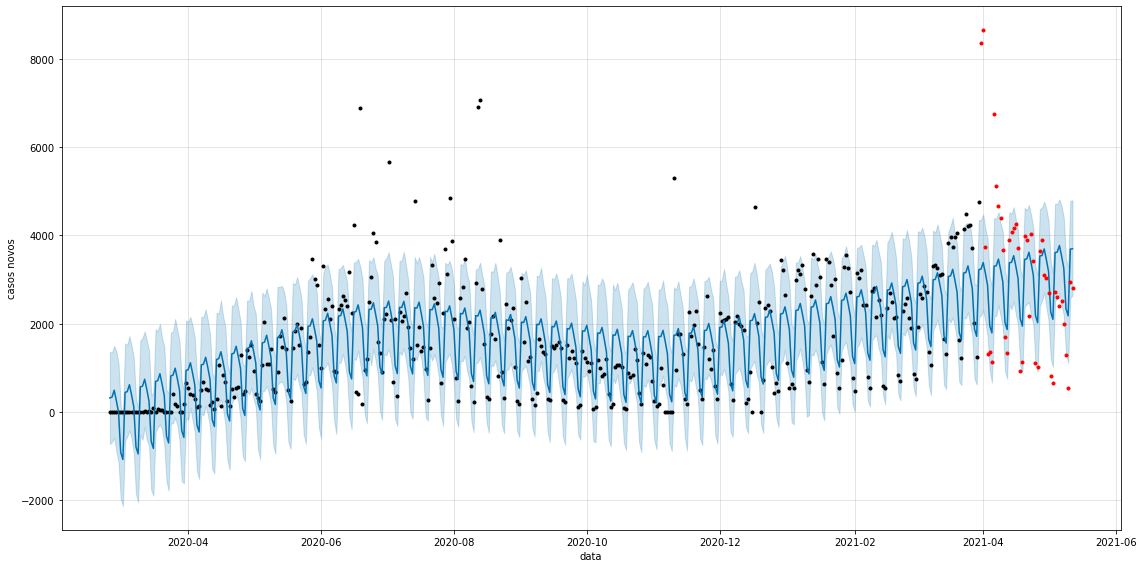

In [ ]:
df_teste = pd.DataFrame()
df_teste['ds'] = dados_sp['datahora'][400:]
df_teste['y'] = dados_sp['casos_novos'][400:]

import matplotlib.pyplot as plt
modelo.plot(previsao, xlabel='data', ylabel='casos novos', figsize=(16,8))
plt.plot(df_teste['ds'], df_teste['y'], '.r')   # ".r" significa que o estilo de plotagem é pontos vermelhos

## Separando os componentes da previsão

Para gerar o dataframe `previsao`, o fbprophet soma uma série de ajustes, resultados dos padrões que ele encontra. Podemos visualizar as curvas desses ajustes através de `plot_components`. 

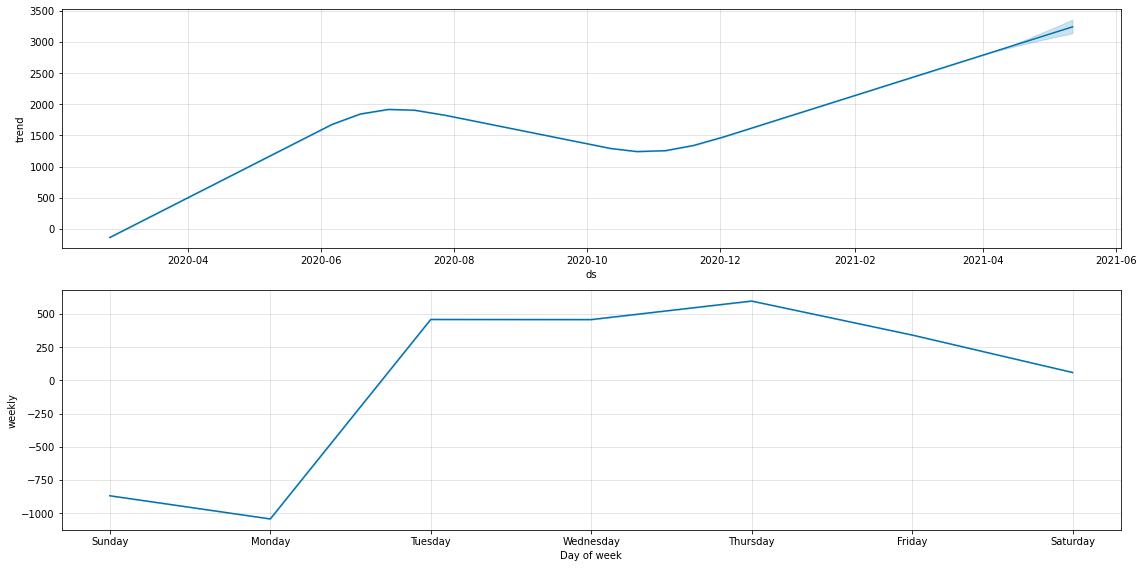

In [ ]:
modelo.plot_components(previsao, figsize=(16,8));

Como resultado temos 2 gráficos: um com um eixo "trend", que nos mostra a tendência geral que ele encontrou nos dados. O outro gráfico mostra a tendência **semanal** que ele encontrou (por isso ele não desativou a sazonalidade semanal!).

## Desafios:

Desafio 08: Mudar os períodos de previsão.

Desafio 09: Explorar a documentação do Prophet e melhorar os gráficos.

Desafio 10: Fazer todo o processo de previsão para o número de casos acumulados.

### Desafio 08

Vamos utilizar o modelo e fazer o mesmo gráfico para diferentes períodos de tempo, portanto vamos fazer funções para executar os comandos. A função `split_teste_train` separa os dataframes `df_train` e `df_test` de acordo com 2 parâmetros, `period`, que conta quantos dias deixaremos para realizar o teste, e `percent_test`, recebe a porcentagem dos dados que queremos deixar para teste. Só é necessário informar um desses parâmetros. Se for informado a porcentagem, o período não será levado em conta.

A função `plot.prediction` faz todo o papel, desde instanciar um novo objeto para fazer o modelo, até plotar o gráfico da curva do modelo junto com os dados de teste e treino.

In [ ]:
def split_test_train(data, ds='datahora', y='casos_novos', period=30, percent_test=None):

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()
  
  if percent_test == None:
    x = data.shape[0] - period
  else:
    x = int(data.shape[0] * (1-percent_test))

  df_train['ds'] = data[ds][:x]
  df_train['y'] = data[y][:x]
  df_test['ds'] = data[ds][x:]
  df_test['y'] = data[y][x:]

  return df_train, df_test

def plot_prediction(df_train, df_test):

  # instanciando e executando o fit
  model = Prophet()
  model.fit(df_train)

  # fazendo a previsão
  df_future = model.make_future_dataframe(periods=df_test.shape[0])
  predict = model.predict(df_future)

  #plot
  model.plot(predict, xlabel='data', ylabel='casos', figsize=(16,8));
  plt.plot(df_test['ds'], df_test['y'], '.r')


Vamos primeiramente ver o que acontece se fizermos uma escolha ruim de separação entre teste e treino. Separaremos 30% dos dados para treino e os outros 70% para teste.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


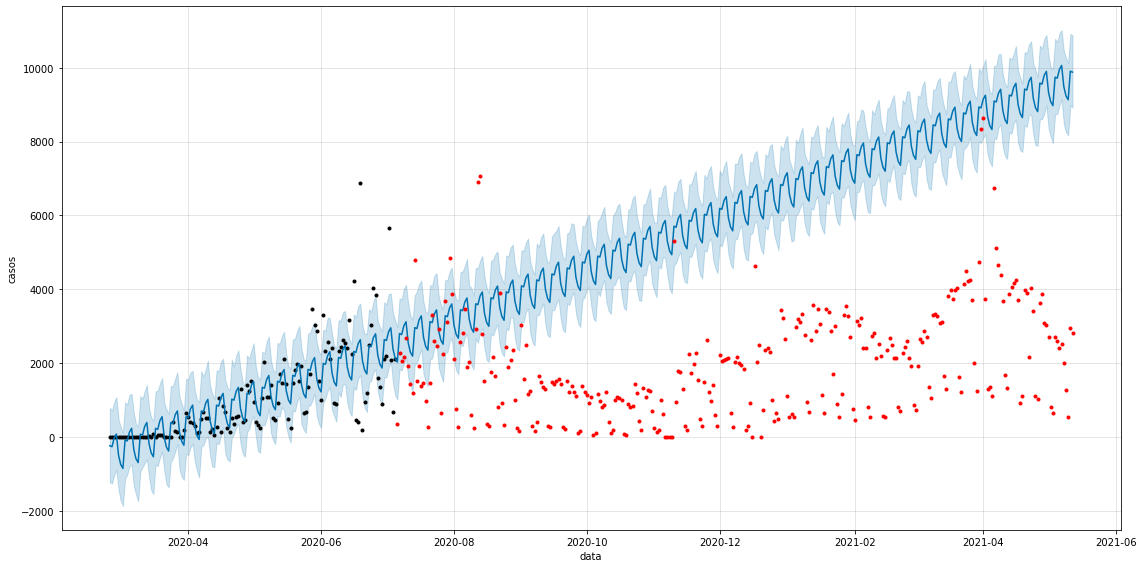

In [ ]:
df_train, df_test = split_test_train(dados_sp, 'datahora', 'casos_novos', percent_test=0.7)
predict = plot_prediction(df_train, df_test)


Percebe-se claramente que, com poucos dados de treino, não é possível observar a tendência geral dos dados. O prophet só identificou a tendência semanal.

Vamos agora testar a previsão para diferentes períodos: uma semana, um mês, 3 meses e um semestre (aproximadamente!).

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


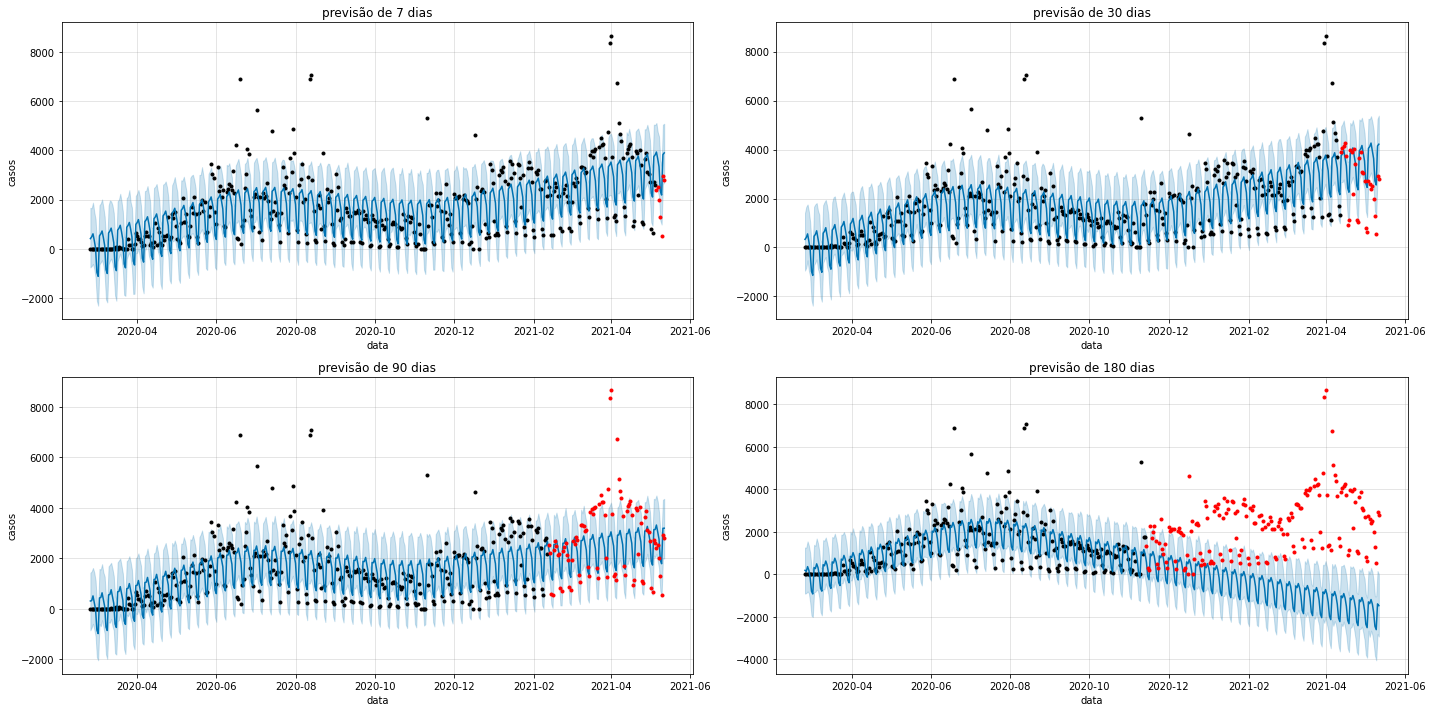

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

periodos = [7, 30, 90, 180]
i=0
j=0

for periodo in periodos:
  df_train, df_test = split_test_train(dados_sp, 'datahora', 'casos_novos', periodo)
  # instanciando e executando o fit
  model = Prophet()
  model.fit(df_train)
  # fazendo a previsão
  df_future = model.make_future_dataframe(periods=periodo)
  predict = model.predict(df_future)
  # plot
  model.plot(predict, xlabel='data', ylabel='casos novos', ax=ax[i,j])
  ax[i,j].plot(df_test['ds'], df_test['y'], '.r')
  ax[i,j].set_title(f'previsão de {periodo} dias')
  if i==0:
    if j==0:
      j=1
    else:
      j=0
      i=1
  else:
    if j==0:
      j=1
    else:
      i=0
      j=0



Agora fica mais claro ainda que, quanto menos dados para treino nós disponibilizamos ao prophet, menos informação ele terá para captar a tendência geral do comportamento dos dados.

### Desafio 09: Explorar a documentação do Prophet e melhorar os gráficos.

Na [API do fbprophet](https://facebook.github.io/prophet/docs/quick_start.html) é possível ver que ele faz gráficos interativos, usando o plotly. Vamos testar como são executados esses gráficos.

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

df_train, df_test = split_test_train(dados_sp)
model = Prophet()
model.fit(df_train)
df_future = model.make_future_dataframe(periods=30)
forecast = model.predict(df_future)
plot_plotly(model, forecast, figsize=(1400, 700))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


é possível também um gráfico interativo com as componentes das tendências que o prophet encontra:

In [ ]:
plot_components_plotly(model, forecast, figsize=(1300,350))

### Desafio 10: Fazer todo o processo de previsão para o número de casos acumulados.

O processo é o mesmo e, para economizar algumas linhas de código, vamos utilizar as funções já criadas.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


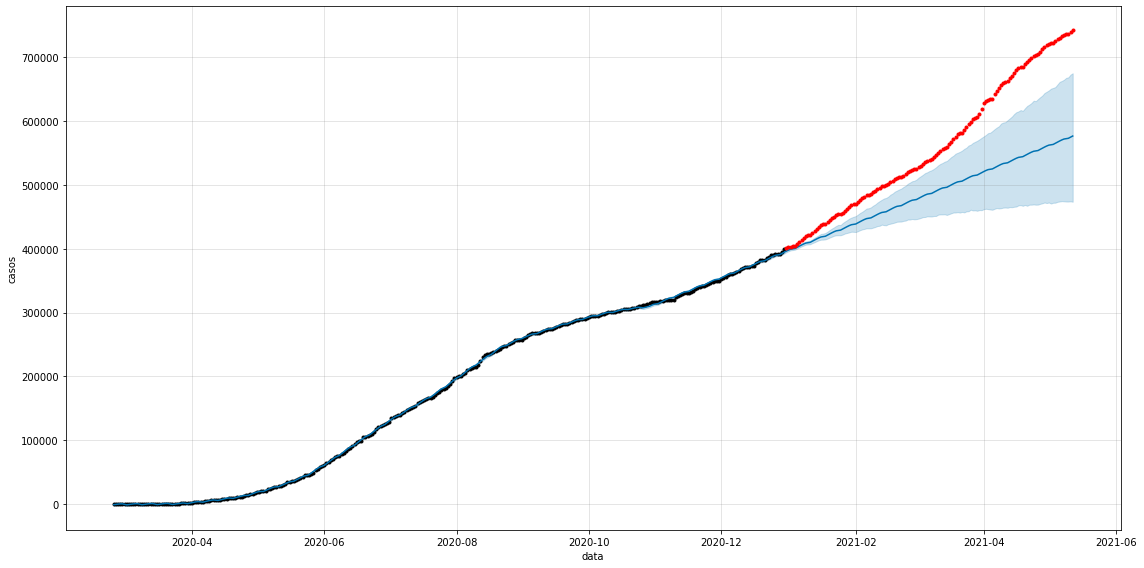

In [ ]:
df_train, df_test = split_test_train(dados_sp, y='casos', percent_test=0.3)
plot_prediction(df_train, df_test)